# NAIAD Tutorial

The purpose of this tutorial is to provide a tutorial about the essential functions to train and evaluate NAIAD. We introduce:
1) NAIAD model and workflow for training a model based on genetic perturbation data and predicting new perturbations
2) Evaluation of NAIAD model performane with the increase of training data

We will use the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) combinatorial perturbation dataset, which contains cell viability measurements for CRISPRa pairwise genetic perturbations of ~120 genes.

Besides the Norman2019 dataset, you can also try out these models on the [Simpson2023](https://www.biorxiv.org/content/10.1101/2023.08.19.553986v1) and [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674\(18\)30735-9) datasets, present within the `./data` subfolder of this `tutorials` directory.

## Set up notebook

In [1]:
import logging
import numpy as np
import pandas as pd
import torch
import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
from naiad import load_naiad_data, NAIAD


In [2]:
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

## NAIAD model training

In [3]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/naiad'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42
n_epoch = 100

# set up how to split data
n_train = 500 
n_val = 1000
n_test = 1000


In [15]:
from naiad.utils import reload_module
reload_module("naiad")
reload_module("naiad.models")
from naiad import load_naiad_data, NAIAD

reloading module naiad
reloading module naiad.models


In [16]:

# load and split data
naiad_data = load_naiad_data(data_file)
#naiad_data['rank'] = np.argsort(np.argsort(naiad_data['comb_score'])) + 1
naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test )
naiad_model.set_seed(seed=seed)
naiad_model.prepare_data()

# initialize model and prepare trainer
naiad_model.initialize_model(device=device, model_args={'embed_model': 'transformer'})
naiad_model.setup_trainer(n_epoch=n_epoch)

In [17]:
# run model training
naiad_model.train_model(ranking_model = False)

In [18]:
# generate predictions using the best model based on the validation loss
naiad_model.generate_preds(use_best=True)

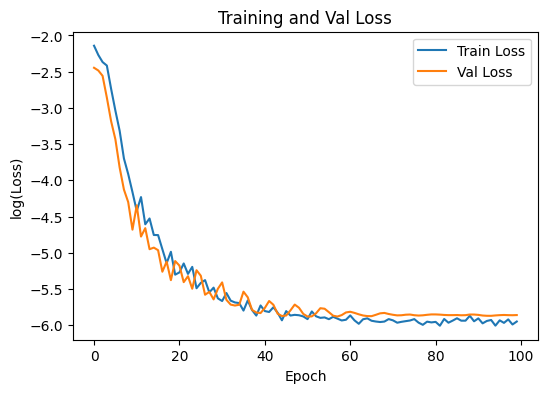

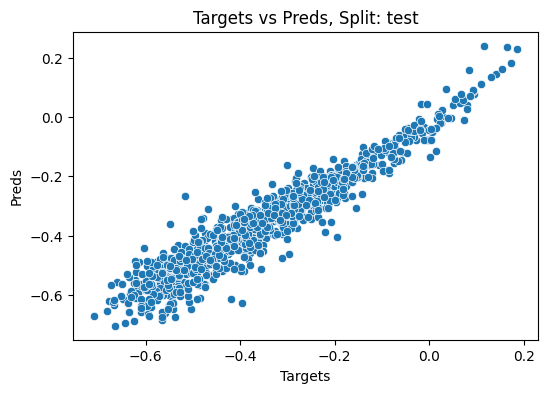

In [21]:
# plot results
fig = naiad_model.plot_loss_curves(log=True)
fig = naiad_model.plot_preds('test')

In [22]:
# extract relevant data from object
model = naiad_model.model                 # final model after training
best_model = naiad_model.best_model       # best model after training based on minimum val loss
preds = naiad_model.preds                 # predictions from best model on all data splits
losses = naiad_model.training_metrics     # train / val loss during training process

## Evaluation performance of NAIAD model with the increase of training data
Here we demonstrate how to train the model by one replicates and by ensembled model

In [23]:
n_train_set = range(100, 3000, 200)
n_val = 1000
n_test = 1000
n_epoch = 100
train_loss = []
val_loss = []
test_loss = []
emb_model = 'transformer'

for n_train in tqdm.tqdm(n_train_set):
    naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test)
    naiad_model.set_seed(seed=seed)
    naiad_model.prepare_data()

    naiad_model.initialize_model(device=device, model_args={'embed_model': emb_model})
    naiad_model.setup_trainer(n_epoch=n_epoch)
    naiad_model.train_model()
    
    losses = naiad_model.training_metrics  
    loss_index = np.argmin(losses['val_loss'])
    train_loss.append( losses['train_loss'][loss_index])
    val_loss.append( losses['val_loss'][loss_index])
    test_loss.append( losses['test_loss'][loss_index])
    

100%|██████████| 15/15 [01:16<00:00,  5.07s/it]


<Axes: >

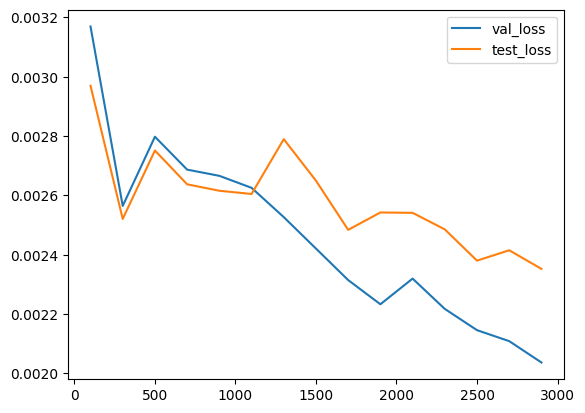

In [24]:
sns.lineplot(x=n_train_set, y=val_loss, label='val_loss')
sns.lineplot(x=n_train_set,y=test_loss, label='test_loss')

### Train the model with replicates

In [ ]:
from naiad.utils import EnsembleModels
n_ensemble = 10
n_train_set = range(100, 3000, 200)
n_val = 1000

loss_metric = pd.DataFrame(columns=['val_loss_mean', 'test_loss_mean', 'val_loss_std', 'test_loss_std'], index=n_train_set, dtype=float)

import tqdm 
n_train_set = range(100, 3000, 200)
n_val = 1000
n_test = 1000
n_epoch = 100
emb_model = 'transformer'

 
for n_train in tqdm.tqdm(n_train_set):
    naiad_model = NAIAD(naiad_data, n_train=n_train, n_val=n_val, n_test=n_test )
    _, ensemble_loss = EnsembleModels(model=naiad_model, n_ensemble=n_ensemble, device=device, model_args={'embed_model': emb_model, 'p_dropout':0.1})
    ensemble_loss_index = [np.argmin(loss_i['val_loss']) for loss_i in ensemble_loss ]

    ensemble_val_loss = np.array([ensemble_loss[i]['val_loss'][ensemble_loss_index[i]] for i in range(len(ensemble_loss)) ])
    ensemble_test_loss = np.array([ensemble_loss[i]['test_loss'][ensemble_loss_index[i]] for i in range(len(ensemble_loss)) ])
    
    loss_metric.loc[n_train] = [np.mean( ensemble_val_loss), np.mean(ensemble_test_loss),\
                                  np.std(ensemble_val_loss),  np.std(ensemble_test_loss)]

    

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.array(n_train_set), np.log(loss_metric['val_loss_mean']), label='Val loss mean', linestyle='-')
plt.plot(n_train_set, np.log(loss_metric['test_loss_mean']), label='Test loss mean',   linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Test Loss with the increase of training data')
plt.legend()
plt.grid(True)
plt.show()